Submitted by:
- Shubham Singh (02131135) 
- Pranshu Acharya (02118866) 
- Shrishti Sudhakar Shetty (02086420)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# QuickSort Algorithm

Quicksort is a sorting algorithm that uses the concept of Divide and Conquer, i.e it breaks down the problem into smaller sections and combines the solutions to get the final output. 
The algorithm works by picking a pivot element in the array, partition the array based on if the elements are less than the pivot or more than the pivot, and redo the whole thing, until we get the full sorted array.

Algorithm:

1. Get the input array.
2. Select a pivot element.
3. Divide the array into two parts: elements less than pivot, elements more than pivot.
4. Repeat steps 2,3 until a min length of array.
5. Combine all the smaller arrays.


# Input numbers generator

The input for the algorithm to solve is a file which contains numbers random number between 1 and 1000000 in each line generated using the rand() function.

```c
    FILE *file = fopen(argv[2], "w");

#pragma omp parallel
    {
        unsigned int thread_seed = common_seed + omp_get_thread_num();
        srand(thread_seed);

#pragma omp for
        for (int i = 0; i < N; ++i)
        {
            int randomNumber = rand() % 1000000 + 1;

#pragma omp critical
            fprintf(file, "%d\n", randomNumber);
        }
    }

    fclose(file);


```

For the Weak Scaling Test we use later, a script had to be written to vary the number of random variables.

```bash
#!/bin/bash
i=1
while [ $i -le 128 ]; do
    ./random_generator $((100000 * i)) WeakScalingValues/$i.dat
    i=$((i * 2))
done

```

# Parallelization in C

For parallelizing the algorithm, we use a different approach. Since it is a recursive algorithm, using critical, atomic sections or reduction techniques seemed inappropriate. Instead we are using sections, which can be used to differentiate portions of the code which can be run in parallel. 

```c
#pragma omp section
{
    quicksort(arr, start, index - 1);
}
#pragma omp section
{
    quicksort(arr, index + 1, end);
}

```

Here, after sorting the array based on the pivot, we seperate the quicksort into two partitions which are run in parallel.

## Strong Scaling Test

In [20]:
df_SS = pd.read_csv("AnvilDir/SS.o4130433",header=None, names=["Threads","Time"])
df_SS["Speedup"]=df_SS["Time"][0]/df_SS["Time"]
df_SS.head(3)

,Threads,Time,Speedup
0,1,0.073974,1.000000
1,2,0.038916,1.900863
2,4,0.024886,2.972515


Text(0.5, 1.0, 'Strong Scale Speedup Test')

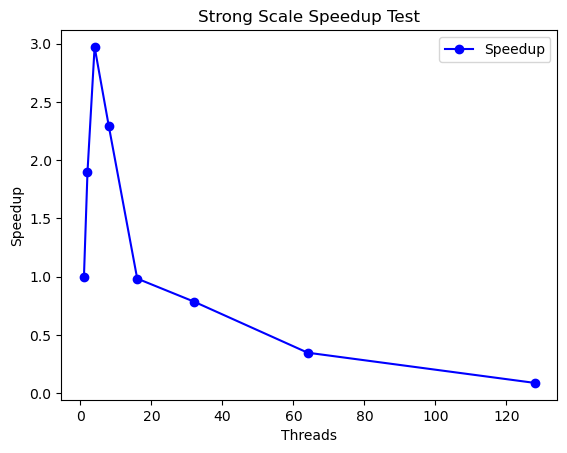

In [7]:
plt.plot(df_SS["Threads"],df_SS["Speedup"],"o-b",label="Speedup")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.legend()
plt.title("Strong Scale Speedup Test")

## Weak Scaling Test

In [21]:
df_WS = pd.read_csv("AnvilDir/WS.o4130431",header=None, names=["Threads","Time"])
df_WS["Speedup"]=df_WS["Time"][0]/df_WS["Time"]
df_WS.head(3)

,Threads,Time,Speedup
0,1,0.013164,1.000000
1,2,0.015679,0.839594
2,4,0.022667,0.580756


Text(0.5, 1.0, 'Weak Scale Speedup Test')

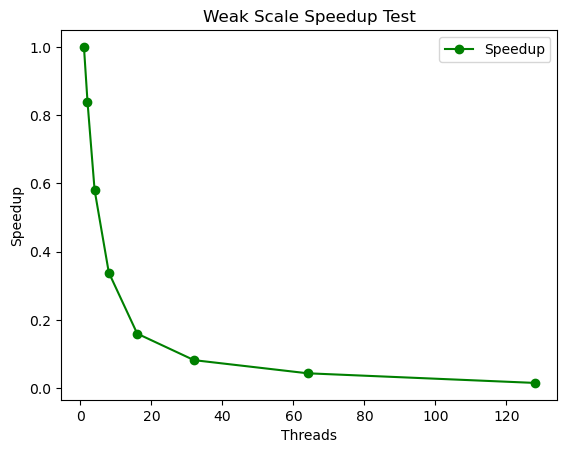

In [10]:
plt.plot(df_WS["Threads"],df_WS["Speedup"],"o-g",label="Speedup")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.legend()
plt.title("Weak Scale Speedup Test")

# Parallization in Java

In java, we can dynamically spawn child threads, which solves a huge hurdle in the case of quick sort as it is a recursive method. Fork-Join framework is used here to implement parallel quicksort. It is part of the java.util.concurrent package and provides a way to parallelize tasks by dividing them into smaller subtasks that can be executed concurrently, exactly how QuickSort works.The number of threads used are controlled in the ForkJoinPool

```java
ForkJoinPool forkJoinPool = new ForkJoinPool(numThreads);
```

A Threshold of 20 is used so that when the size of the array is less than 20, a serial quicksort is used instead, removing unnecessary thread overhead.

```java
if (high - low < THRESHOLD) {
                serialQuickSort(array, low, high);
            } else {
                int partitionIndex = parallelPartition(array, low, high);

                invokeAll(new ParallelQuickSort(array, low, partitionIndex - 1),
                        new ParallelQuickSort(array, partitionIndex + 1, high));

```

## Strong Scale Speedup

In [22]:
df_java = pd.read_csv("JavaTimings.dat",header=None, names=["Threads","Time"])
df_java["Speedup"]=df_java["Time"][0]/df_java["Time"]
df_java.head(3)

,Threads,Time,Speedup
0,1,25158600,1.000000
1,2,23932500,1.051232
2,4,24301700,1.035261


Text(0.5, 1.0, 'Strong Scale Test in Java')

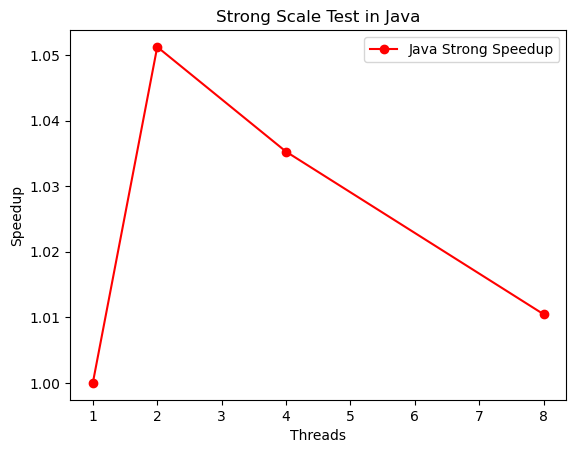

In [18]:
plt.plot(df_java["Threads"],df_java["Speedup"],"o-r",label="Java Strong Speedup")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.legend()
plt.title("Strong Scale Test in Java")

These speedups are really small. A scaleup of 1.05 is very insignifacnt. On top of that, the speedup nearly reaches 1 after 8 threads. This shows that the parallization part still needs some work or the number of tasks being parallelized need to be increased.

## Comparison with C

Text(0.5, 1.0, 'Strong Scale Comparison')

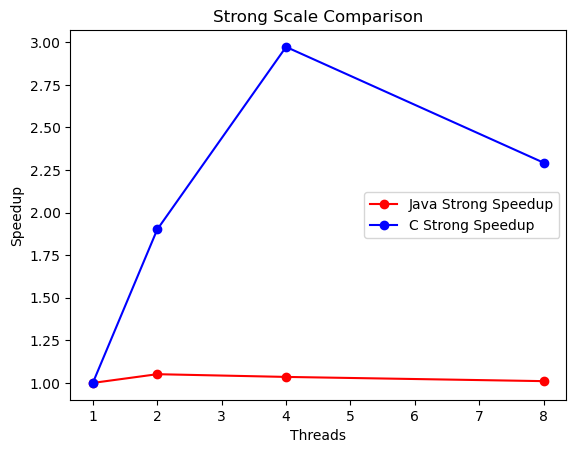

In [19]:
plt.plot(df_java["Threads"],df_java["Speedup"],"o-r",label="Java Strong Speedup")
plt.plot(df_SS[:4]["Threads"],df_SS[:4]["Speedup"],"o-b",label="C Strong Speedup")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.legend()
plt.title("Strong Scale Comparison")

This graph clearly shows the distinction between the implementation in C and Java. However, we see a decline in speedup even for C, which can be improved by increasing the parallization efficiency.

# References
http://www.java2s.com/Tutorials/Java/Java_Thread_How_to/Concurrent/Do_quick_sort_with_ForkJoinPool_and_RecursiveAction.htm
https://www.geeksforgeeks.org/quick-sort-using-multi-threading/